# Propser Marketplace Loan Risk Analysis (Probability of Default Prediction)

## Import data and packages

In [497]:
# load packages
import pandas as pd
import numpy as np
from google.colab import (drive, files)
import os
from functools import reduce
import datetime
# visualization
import matplotlib.pyplot as plt

import seaborn as sns
#!pip install plotly --upgrade
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.tools as tls
import plotly.figure_factory as ff
import IPython
%matplotlib inline
#variable selection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

#import classifer
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from patsy import dmatrices

#model validation matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, auc,classification_report, roc_auc_score, roc_curve, scorer, f1_score, precision_score, recall_score, make_scorer


## Data Preprocessing

In [ ]:
##connect to drive
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive"
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
# read csv
data=pd.read_csv("My Drive/2020 Winter Group 23/BAX452/final prj/prosperLoanData.csv")

In [ ]:
data.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,...,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,...,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,...,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,...,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN,Executive,Employed,44.0,

In [ ]:
data.shape

(113937, 81)

In [ ]:
data.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,1.139370e+05,113937.000000,113912.000000,113937.000000,113937.000000,84853.000000,84853.000000,84853.000000,84853.000000,84853.000000,113937.000000,106312.000000,113346.000000,113346.000000,106333.000000,106333.000000,113240.000000,113937.00000,113937.000000,113240.000000,112778.000000,113240.000000,106315.000000,112947.000000,113240.000000,106333.000000,1.063330e+05,106333.000000,106393.000000,106393.000000,106393.000000,106393.000000,105383.000000,1.139370e+05,22085.000000,22085.000000,22085.000000,22085.000000,22085.000000,22085.000000,22085.000000,18928.000000,113937.000000,16952.000000,113937.000000,113937.000000,113937.00000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,6.278857e+05,40.830248,0.218828,0.192764,0.182701,0.168661,0.080306,0.096068,4.072243,5.950067,2.774209,96.071582,685.567731,704.567731,10.317192,9.260164,26.754539,6.96979,398.292161,1.435085,5.584405,0.592052,984.507059,4.154984,0.312646,0.015094,1.759871e+04,0.561309,11210.225447,23.230034,0.885897,0.802327,0.275947,5.608026e+03,1.421100,22.934345,22.271949,0.613629,0.048540,8472.311961,2930.313906,-3.223214,152.816539,16.268464,31.896882,69444.474271,8337.01385,272.475783,4183.079489,3105.536588,1077.542901,-54.725641,-14.242698,700.446342,681.420499,25.142686,0.998584,0.048027,0.023460,16.550751,80.475228
std,3.280762e+05,10.436212,0.080364,0.074818,0.074516,0.068467,0.046764,0.030403,1.673227,2.376501,3.996797,94.480605,66.458275,66.458275,5.457866,5.022644,13.637871,4.63097,447.159711,2.437507,6.429946,1.978707,7158.270157,10.160216,0.727868,0.154092,3.293640e+04,0.317918,19818.361309,11.871311,0.148179,1.097637,0.551759,7.478497e+03,0.764042,19.249584,18.830425,2.446827,0.556285,7395.507650,3806.635075,50.063567,466.320254,9.005898,29.974184,38930.479610,6245.80058,192.697812,4790.907234,4069.527670,1183.414168,60.675425,109.232758,2388.513831,2357.167068,275.657937,0.017919,0.332353,0.232412,294.545422,103.239020
min,4.000000e+00,12.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-209.000000,0.000000,0.000000,0.000000,1.000000,1000.00000,0.000000,-2.349900,0.000000,-2.349900,-664.870000,-9274.750000,-94.200000,-954.550000,0.000000,0.700000,0.000000,0.000000,0.000000,1.000000
25%,4.009190e+05,36.000000

In [ ]:
## dataset overview
for var in data.columns:
  uniques = data[var].unique()
  print('{0:20s} {1:5d}\t'.format(var,len(uniques)), data[var].isnull().sum(),'null \t', data[var].dtype, '\t',uniques[:10])

ListingKey           113066	 0 null 	 object 	 ['1021339766868145413AB3B' '10273602499503308B223C1'
 '0EE9337825851032864889A' '0EF5356002482715299901A'
 '0F023589499656230C5E3E2' '0F05359734824199381F61D'
 '0F0A3576754255009D63151' '0F1035772717087366F9EA7'
 '0F043596202561788EA13D5' '0F123545674891886D9F106']
ListingNumber        113066	 0 null 	 int64 	 [ 193129 1209647   81716  658116  909464 1074836  750899  768193 1023355
  587746]
ListingCreationDate  113064	 0 null 	 object 	 ['2007-08-26 19:09:29.263000000' '2014-02-27 08:28:07.900000000'
 '2007-01-05 15:00:47.090000000' '2012-10-22 11:02:35.010000000'
 '2013-09-14 18:38:39.097000000' '2013-12-14 08:26:37.093000000'
 '2013-04-12 09:52:56.147000000' '2013-05-05 06:49:27.493000000'
 '2013-12-02 10:43:39.117000000' '2012-05-10 07:04:01.577000000']
CreditGrade              9	 84984 null 	 object 	 ['C' nan 'HR' 'AA' 'D' 'B' 'E' 'A' 'NC']
Term                     3	 0 null 	 int64 	 [36 60 12]
LoanStatus              12	 0 null 	 o

### Data Wrangling

#### 1. Dropping unnecessary columns


In [ ]:
## Dropping unecessary columns
drop_cols=['ListingKey', 'ListingNumber','LP_CustomerPayments','LP_CustomerPrincipalPayments','LP_InterestandFees','LP_ServiceFees','LP_CollectionFees','LP_GrossPrincipalLoss',
'LP_NetPrincipalLoss','LP_NonPrincipalRecoverypayments','ListingCreationDate','ClosedDate','FirstRecordedCreditLine','ProsperRating (numeric)','BorrowerState','CurrentlyInGroup', 'GroupKey','DateCreditPulled','LoanKey', 'LoanNumber','LoanOriginationDate', 'LoanOriginationQuarter', 'ScorexChangeAtTimeOfListing','MemberKey']
data_sub=data.drop(columns=drop_cols,axis=1)

#### 2. Subset Loan Status, removing LoanStatus='Current'



In [ ]:
##exluding current loans because there is no way to predict current ones. 
data_sub=data_sub[~data_sub['LoanStatus'].isin(['Current'])]

In [ ]:
data_sub.shape

(57361, 57)

#### 4.Deal with missing values

fillna(0) <br>
TotalProsperLoans
TotalProsperPaymentsBilled
OnTimeProsperPayments
ProsperPaymentsLessThanOneMonthLate
ProsperPaymentsOneMonthPlusLate
ProsperPrincipalBorrowed
ProsperPrincipalOutstanding
LoanFirstDefaultedCycleNumber 

In [ ]:
data_sub[['TotalProsperLoans','TotalProsperPaymentsBilled','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ProsperPrincipalBorrowed','ProsperPrincipalOutstanding',
'LoanFirstDefaultedCycleNumber']]=data_sub[['TotalProsperLoans','TotalProsperPaymentsBilled','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ProsperPrincipalBorrowed','ProsperPrincipalOutstanding',
'LoanFirstDefaultedCycleNumber']].fillna(0)

In [ ]:
data_sub.head()

,CreditGrade,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,C,36,Completed,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,0,Other,Self-employed,2.0,True,640.0,659.0,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,78,9425,330.43,1.0,0,0,0.0,258
2,HR,36,Completed,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,0,Other,Not available,NaN,False,480.0,499.0,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,86,3001,123.32,1.0,0,0,0.0,41
11,C,36,Completed,0.15033,0.1325,0.1225,NaN,NaN,NaN,NaN,NaN,0,Waiter/Waitress,Full-time,19.0,False,640.0,659.0,2.0,2.0,10.0,1,40.0,3.0,5.0,3.0,2224.0,1.0,0.0,0.0,1220.0,0.32,2580.0,7.0,0.40,0.0,0.27,"$1-24,999",True,1666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,77,1000,33.81,1.0,0,0,0.0,53
12,NaN,36,Past Due (1-15 days),0.17969,0.1435,0.1335,0.1264,0.0524,0.0740,B,4.0,1,Sales - Retail,Employed,1.0,False,680.0,699.0,9.0,7.0,29.0,8,290.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,8624.0,0.70,3626.0,20.0,1.00,0.0,0.18,"$25,000-49,999",True,2416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,2,4000,137.39,1.0,0,0,0.0,1
15,NaN,36,Defaulted,0.35797,0.3177,0.3077,0.2896,0.1650,0.1246,HR,5.0,13,Other,Other,121.0,True,700.0,719.0,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,"$50,000-74,999",True,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140,8.0,23,4000,173.71,1.0,0,0,0.0,10


calculate missing numerical values

In [ ]:
data_sub["BorrowerAPR"].fillna(data_sub["BorrowerRate"] + (data_sub["BorrowerAPR"] - data_sub["BorrowerRate"]).median(), inplace=True)
data_sub["BorrowerAPR"].isnull().sum()

0

In [ ]:
data_sub["EstimatedEffectiveYield"].fillna(data_sub["BorrowerRate"] - (data_sub["BorrowerRate"] - data_sub["EstimatedEffectiveYield"]).median(), inplace=True)
data_sub["EstimatedEffectiveYield"].isnull().sum()

0

In [ ]:
data_sub["EstimatedLoss"].fillna(data_sub["EstimatedLoss"].median(), inplace=True)
data_sub["EstimatedLoss"].isnull().sum()

0

In [ ]:
data_sub["EstimatedReturn"].fillna(data_sub["EstimatedEffectiveYield"] - data_sub["EstimatedLoss"], inplace=True)
data_sub["EstimatedReturn"].isnull().sum()

0

In [ ]:
data_sub["ProsperScore"].fillna(data_sub["ProsperScore"].median(), inplace=True)
data_sub["ProsperScore"].isnull().sum()

0

Fill in categorical values of credit grade

In [ ]:
data_sub['ProsperRating (Alpha)']=data_sub['ProsperRating (Alpha)'].fillna(data_sub['CreditGrade'])
data_sub=data_sub.drop(columns='CreditGrade',axis=1)

In [ ]:
data_sub.drop(data_sub[data_sub['ProsperRating (Alpha)'].isnull()].index,inplace =True)

In [ ]:
data_sub.dropna(inplace= True)

In [ ]:
data_sub.shape

(45269, 56)

In [ ]:
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45269 entries, 0 to 113935
Data columns (total 56 columns):
Term                                   45269 non-null int64
LoanStatus                             45269 non-null object
BorrowerAPR                            45269 non-null float64
BorrowerRate                           45269 non-null float64
LenderYield                            45269 non-null float64
EstimatedEffectiveYield                45269 non-null float64
EstimatedLoss                          45269 non-null float64
EstimatedReturn                        45269 non-null float64
ProsperRating (Alpha)                  45269 non-null object
ProsperScore                           45269 non-null float64
ListingCategory (numeric)              45269 non-null int64
Occupation                             45269 non-null object
EmploymentStatus                       45269 non-null object
EmploymentStatusDuration               45269 non-null float64
IsBorrowerHomeowner           

#### 5. Convert Loan Status to Dummy, Defaulted/charged off/past due=1, Completed = 0 

In [ ]:
##convert the loan status to dummy
data_sub['Defaulted']=(~data['LoanStatus'].isin(['Completed','FinalPaymentInProgress'])).astype(int)

In [ ]:
data_sub[['Defaulted','LoanStatus']].head()

,Defaulted,LoanStatus
0,0,Completed
11,0,Completed
12,1,Past Due (1-15 days)
15,1,Defaulted
21,0,Completed


In [ ]:
data_sub.head()

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted
0,36,Completed,0.16516,0.1580,0.1380,0.13462,0.0980,0.03662,C,6.0,0,Other,Self-employed,2.0,True,640.0,659.0,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,78,9425,330.43,1.0,0,0,0.0,258,0
11,36,Completed,0.15033,0.1325,0.1225,0.10912,0.0980,0.01112,C,6.0,0,Waiter/Waitress,Full-time,19.0,False,640.0,659.0,2.0,2.0,10.0,1,40.0,3.0,5.0,3.0,2224.0,1.0,0.0,0.0,1220.0,0.32,2580.0,7.0,0.40,0.0,0.27,"$1-24,999",True,1666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,77,1000,33.81,1.0,0,0,0.0,53,0
12,36,Past Due (1-15 days),0.17969,0.1435,0.1335,0.12640,0.0524,0.07400,B,4.0,1,Sales - Retail,Employed,1.0,False,680.0,699.0,9.0,7.0,29.0,8,290.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,8624.0,0.70,3626.0,20.0,1.00,0.0,0.18,"$25,000-49,999",True,2416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,2,4000,137.39,1.0,0,0,0.0,1,1
15,36,Defaulted,0.35797,0.3177,0.3077,0.28960,0.1650,0.12460,HR,5.0,13,Other,Other,121.0,True,700.0,719.0,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,"$50,000-74,999",True,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140,8.0,23,4000,173.71,1.0,0,0,0.0,10,1
21,36,Completed,0.21488,0.2075,0.1975,0.18412,0.0980,0.08612,D,6.0,0,Professional,Full-time,36.0,False,620.0,639.0,4.0,4.0,13.0,3,15.0,0.0,8.0,1.0,5200.0,5.0,1.0,0.0,134.0,0.08,1366.0,6.0,0.37,0.0,0.09,"$25,000-49,999",True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,75,3000,112.64,1.0,0,0,0.0,53,0


In [ ]:
data_sub.reset_index().drop(columns='index',axis=1)

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted
0,36,Completed,0.16516,0.1580,0.1380,0.13462,0.0980,0.03662,C,6.0,0,Other,Self-employed,2.0,True,640.0,659.0,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,78,9425,330.43,1.0,0,0,0.0,258,0
1,36,Completed,0.15033,0.1325,0.1225,0.10912,0.0980,0.01112,C,6.0,0,Waiter/Waitress,Full-time,19.0,False,640.0,659.0,2.0,2.0,10.0,1,40.0,3.0,5.0,3.0,2224.0,1.0,0.0,0.0,1220.0,0.32,2580.0,7.0,0.40,0.0,0.27,"$1-24,999",True,1666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,77,1000,33.81,1.0,0,0,0.0,53,0
2,36,Past Due (1-15 days),0.17969,0.1435,0.1335,0.12640,0.0524,0.07400,B,4.0,1,Sales - Retail,Employed,1.0,False,680.0,699.0,9.0,7.0,29.0,8,290.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,8624.0,0.70,3626.0,20.0,1.00,0.0,0.18,"$25,000-49,999",True,2416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3,0.0,2,4000,137.39,1.0,0,0,0.0,1,1
3,36,Defaulted,0.35797,0.3177,0.3077,0.28960,0.1650,0.12460,HR,5.0,13,Other,Other,121.0,True,700.0,719.0,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,"$50,000-74,999",True,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,140,8.0,23,4000,173.71,1.0,0,0,0.0,10,1
4,36,Completed,0.21488,0.2075,0.1975,0.18412,0.0980,0.08612,D,6.0,0,Professional,Full-time,36.0,False,620.0,639.0,4.0,4.0,13.0,3,15.0,0.0,8.0,1.0,5200.0,5.0,1.0,0.0,134.0,0.08,1366.0,6.0,0.37,0.0,0.09,"$25,000-49,999",True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,75,3000,112.64,1.0,0,0,0.0,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45264,36,Completed,0.07469,0.0679,0.0579,0.04452,0.0980,-0.05348,AA,6.0,4,Executive,Full-time,69.0,True,760.0,779.0,10.0,8.0,18.0,7,763.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,89961.0,0.72,34415.0,17.0,1.00,1.0,0.06,"$100,000+",True,10333.333333,1.0,6.0,6.0,0.0,0.0,1000.0,847.61,0,0.0,70,4292,132.11,1.0,2,0,0.0,194,0
45265,36,Completed,0.22362,0.1899,0.1799,0.17570,0.0610,0.11470,C,6.0,3,Other,Full-time,22.0,False,740.0,759.0,4.0,3.0,15.0,2,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.00,3746.0,15.0,1.00,0.0,0.27,"$25,000-49,999",True,2333.333333,5.0,47.0,47.0,0.0,0.0,14250.0,0.02,0,0.0,33,2000,73.30,1.0,0,0,0.0,25,0
45266,36,Completed,0.30285,0.2639,0.2539,0.23180,0.1225,0.10930,E,3.0,2,Accountant/CPA,Employed,25.0,False,660.0,679.0,7.0,7.0,14.0,7,135.0,2.0,19.0,0.0,0.0,9.0,0.0,0.0,1109.0,0.11,7537.0,11.0,0.75,1.0,0.05,"$50,000-74,999",True,4333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,8,2500,101.25,1.0,0,0,0.0,26,0
45267,36,FinalPaymentInProgress,0.13220,0.1110,0.1010,0.10070,0.0200,0.08070,A,8.0,7,Professional,Employed,21.0,True,700.0,719.0,14.0,13.0,39.0,9,495.0,1.0,4.0,1.0,5062.0,4.0,0.0,0.0,

In [ ]:
## output the dataset to aviod rerun the dataset.
%cd 
!pwd
data_sub.to_csv("prosper_data.csv",index=True)
files.download('prosper_data.csv')

/root
/root


## Loan Data Analysis

In [2]:
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive"
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
data=pd.read_csv("My Drive/2020 Winter Group 23/BAX452/final prj/prosper_data.csv")

## EDA

In [353]:
data_sub=data
data_sub.head()

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted
0,36,Completed,0.16516,0.1580,0.1380,0.13462,0.0980,0.03662,C,6.0,0,Other,Self-employed,2.0,True,640.0,659.0,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,78,9425,330.43,1.0,0,0,0.0,258,0
1,36,Completed,0.15033,0.1325,0.1225,0.10912,0.0980,0.01112,C,6.0,0,Waiter/Waitress,Full-time,19.0,False,640.0,659.0,2.0,2.0,10.0,1,40.0,3.0,5.0,3.0,2224.0,1.0,0.0,0.0,1220.0,0.32,2580.0,7.0,0.40,0.0,0.27,"$1-24,999",True,1666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,77,1000,33.81,1.0,0,0,0.0,53,0
2,36,Past Due (1-15 days),0.17969,0.1435,0.1335,0.12640,0.0524,0.07400,B,4.0,1,Sales - Retail,Employed,1.0,False,680.0,699.0,9.0,7.0,29.0,8,290.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,8624.0,0.70,3626.0,20.0,1.00,0.0,0.18,"$25,000-49,999",True,2416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,2,4000,137.39,1.0,0,0,0.0,1,1
3,36,Defaulted,0.35797,0.3177,0.3077,0.28960,0.1650,0.12460,HR,5.0,13,Other,Other,121.0,True,700.0,719.0,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,"$50,000-74,999",True,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140,8.0,23,4000,173.71,1.0,0,0,0.0,10,1
4,36,Completed,0.21488,0.2075,0.1975,0.18412,0.0980,0.08612,D,6.0,0,Professional,Full-time,36.0,False,620.0,639.0,4.0,4.0,13.0,3,15.0,0.0,8.0,1.0,5200.0,5.0,1.0,0.0,134.0,0.08,1366.0,6.0,0.37,0.0,0.09,"$25,000-49,999",True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,75,3000,112.64,1.0,0,0,0.0,53,0


In [20]:
plt.figure(figsize=(16,8))
data.corr().style.background_gradient(cmap='coolwarm')

<Figure size 1152x576 with 0 Axes>

##### eployee status 

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

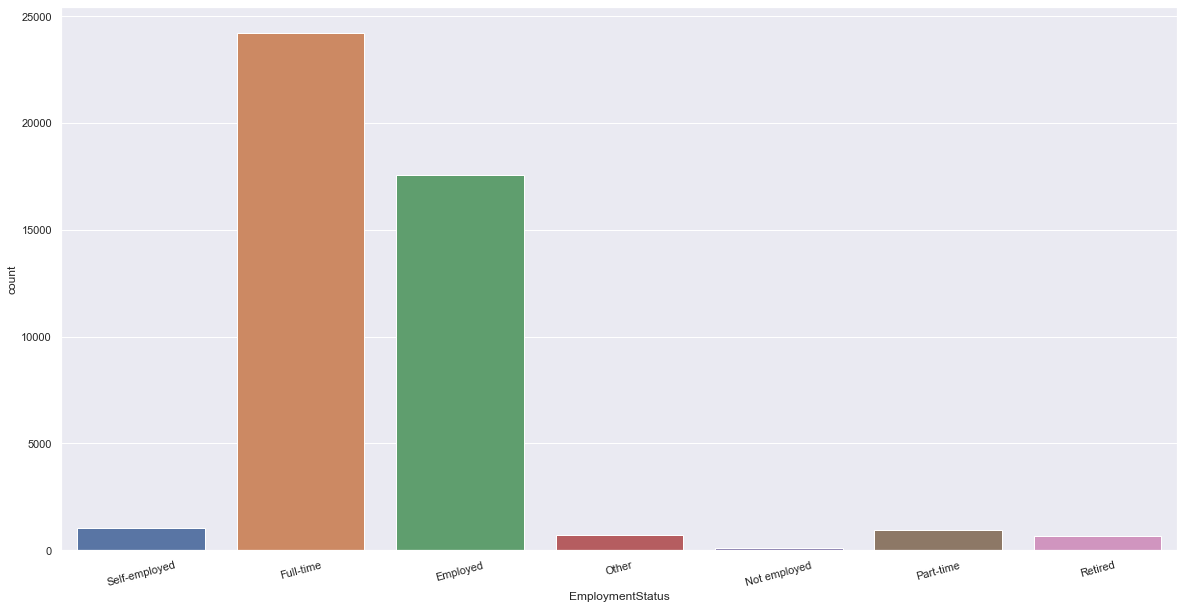

In [67]:
sns.countplot(data=data_sub,x='EmploymentStatus')
plt.xticks(rotation = 15)

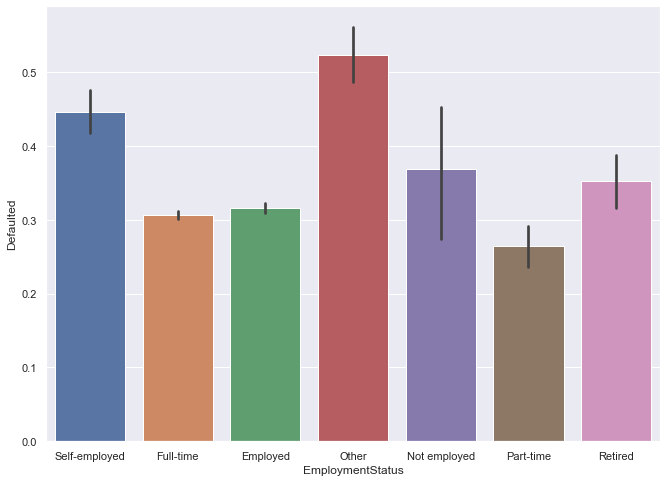

In [44]:
sns.set(rc={'figure.figsize':(11,8)}) 
sns.barplot(x="EmploymentStatus", y="Defaulted", data=data_sub)

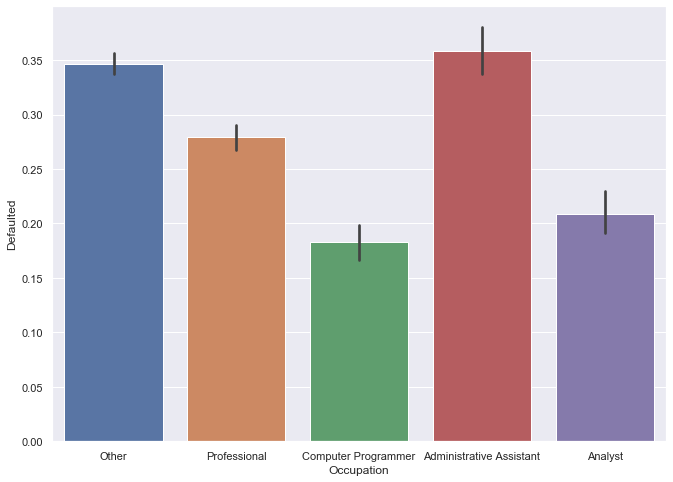

In [48]:
sns.barplot(x="Occupation", y="Defaulted", data=data_sub,order=pd.value_counts(data_sub['Occupation']).iloc[:5].index)

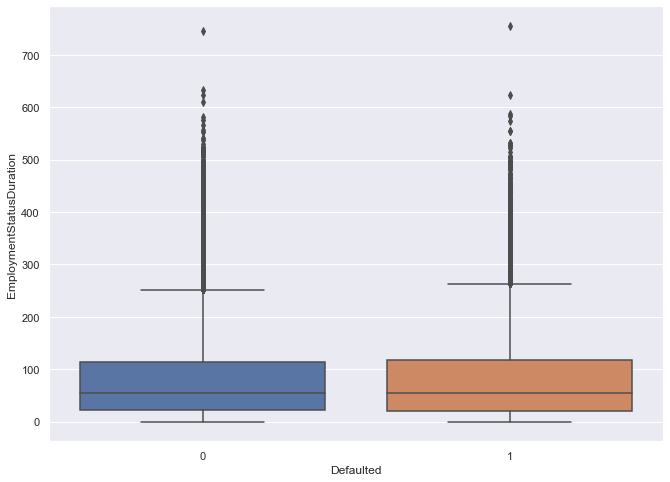

In [46]:
sns.boxplot(x="Defaulted", y="EmploymentStatusDuration", data=data_sub)

##### prosper score

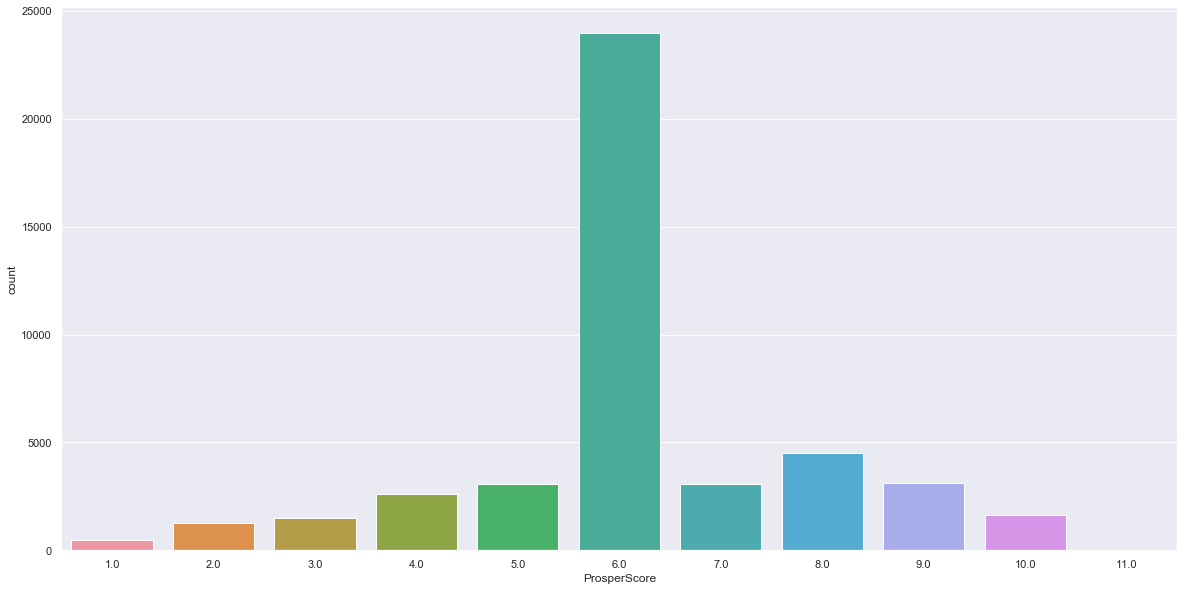

In [65]:
sns.countplot(data=data_sub, x = 'ProsperScore')

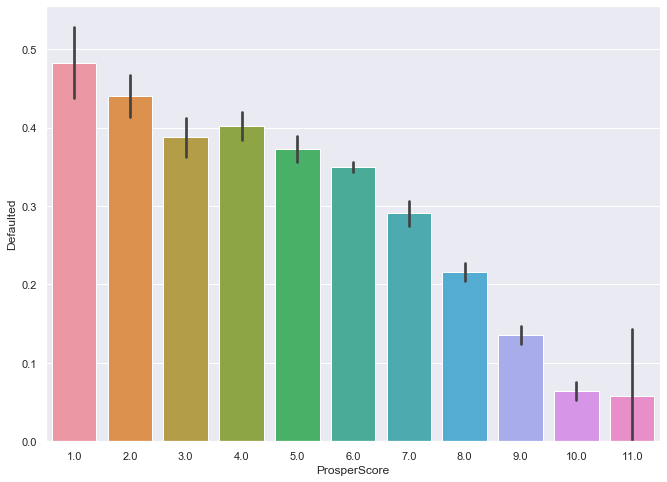

In [47]:
sns.barplot(x="ProsperScore", y="Defaulted", data=data_sub)

In [51]:
data_sub['Term'].value_counts()

36    39910
60     3997
12     1362
Name: Term, dtype: int64

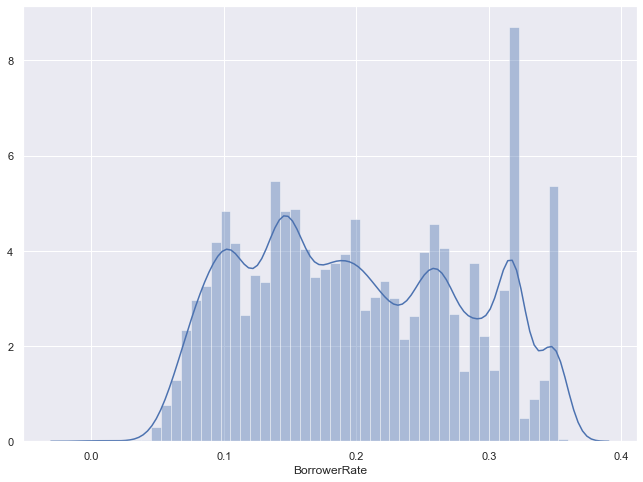

In [52]:
sns.distplot(data_sub['BorrowerRate'])

In [54]:
data_sub["BorrowerRate"].describe()

count    45269.000000
mean         0.200361
std          0.081924
min          0.000000
25%          0.134000
50%          0.192500
75%          0.269900
max          0.360000
Name: BorrowerRate, dtype: float64

#### credit score

In [59]:
data_sub['CreditScore'] = (data_sub['CreditScoreRangeUpper']+data_sub['CreditScoreRangeLower'])/2

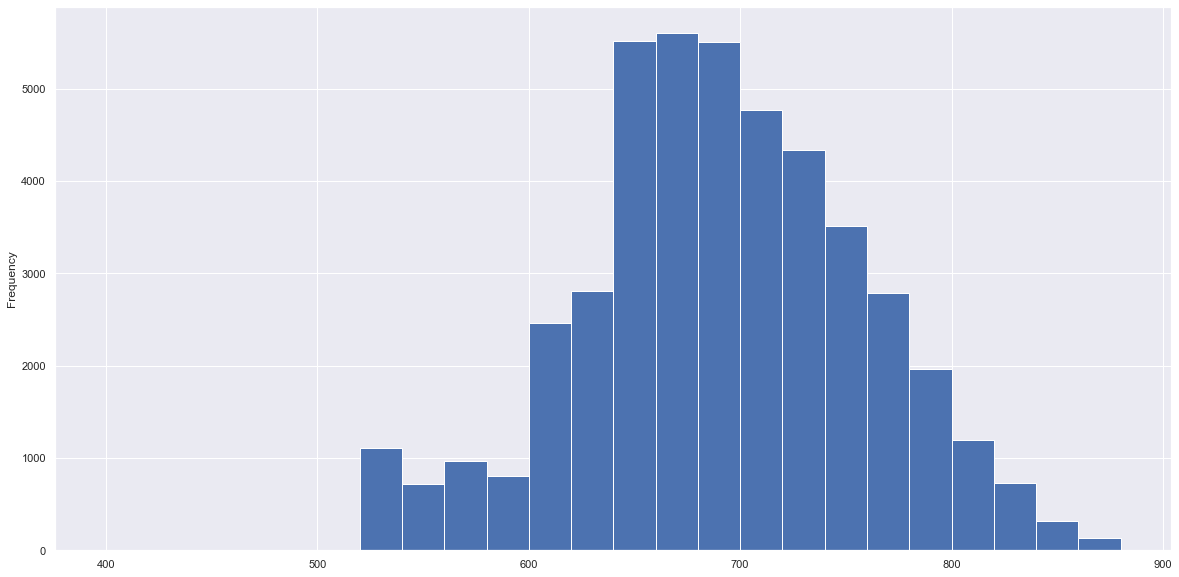

In [68]:
bins = np.arange(400, 900, 20)
data_sub['CreditScore'].plot(kind = 'hist', bins = bins)

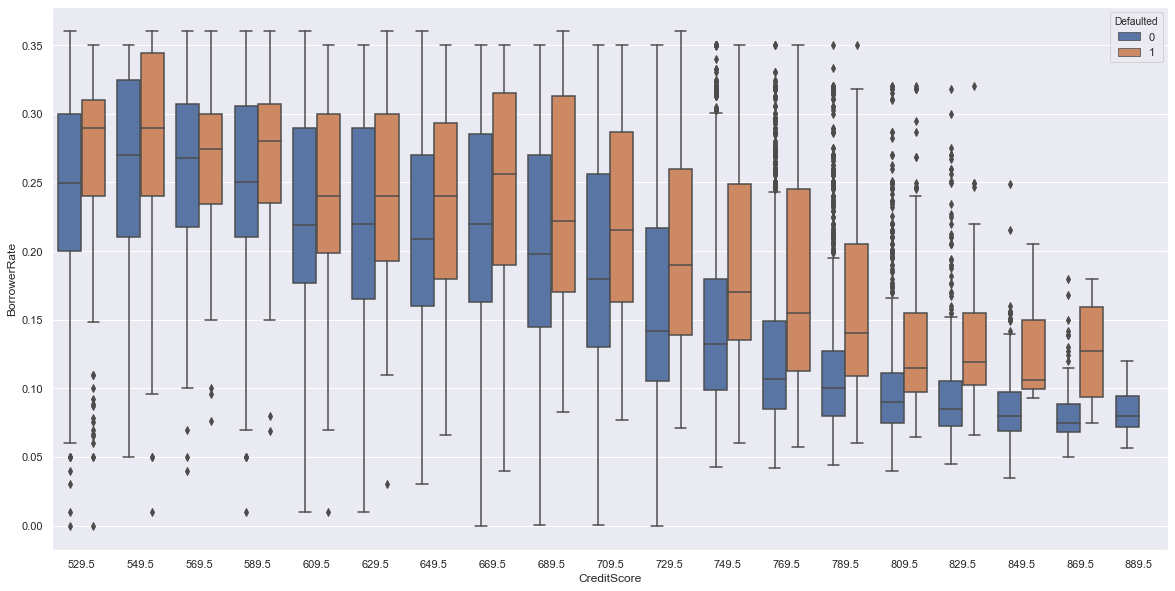

In [62]:
sns.set(rc={'figure.figsize':(20,10)}) 
sns.boxplot(x= 'CreditScore', y = 'BorrowerRate', hue = 'Defaulted' , data =data_sub)

#### debt_ratio

In [26]:
ratio_bin = np.arange(start=0.1,stop = 1, step=0.1)
bins =  pd.cut(data_sub['DebtToIncomeRatio'],ratio_bin)
debt_income_ratio=pd.value_counts(bins)

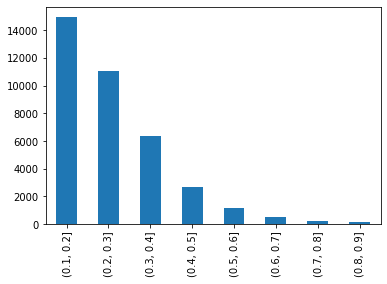

In [14]:
debt_income_ratio.plot(kind = 'bar')

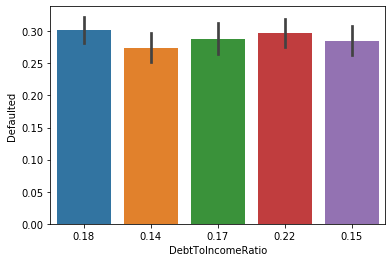

In [20]:
sns.barplot(x="DebtToIncomeRatio", y="Defaulted", data=data_sub,order=pd.value_counts(data_sub['DebtToIncomeRatio']).iloc[:5].index)

#### revolving credit balance

In [98]:
r_bin=np.arange(0,data_sub['RevolvingCreditBalance'].max(),3000)
r_bins = pd.cut(data_sub['RevolvingCreditBalance'],r_bin)
revolving_balance = pd.value_counts(r_bins).head(20)

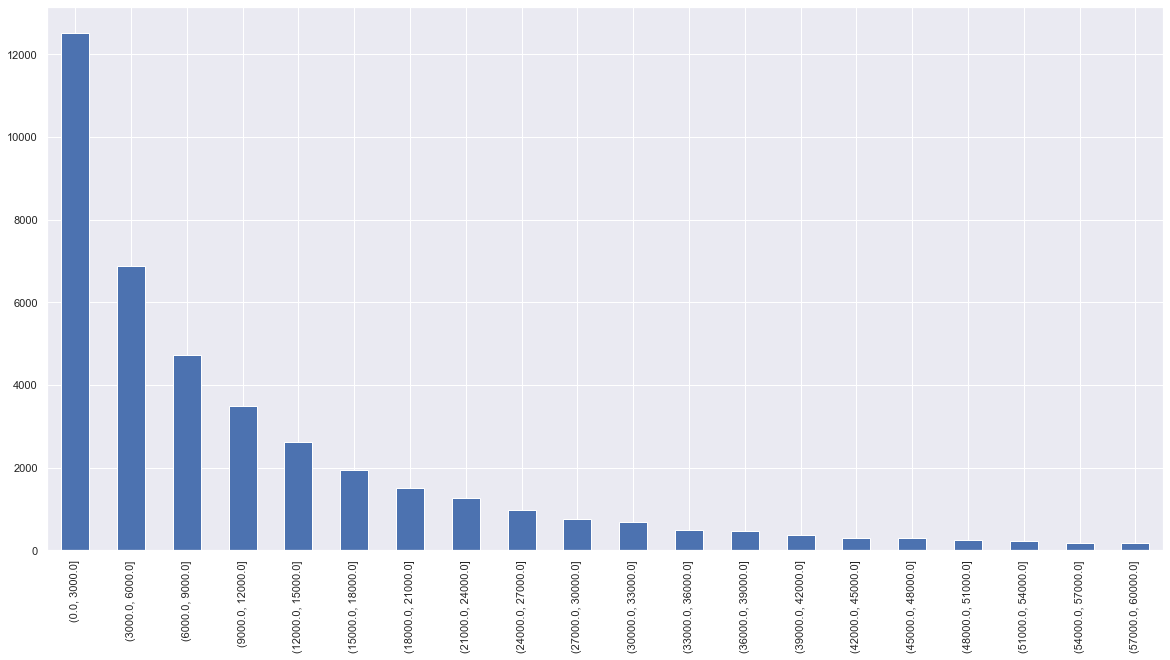

In [99]:
revolving_balance.plot(kind= 'bar')

#### loan status

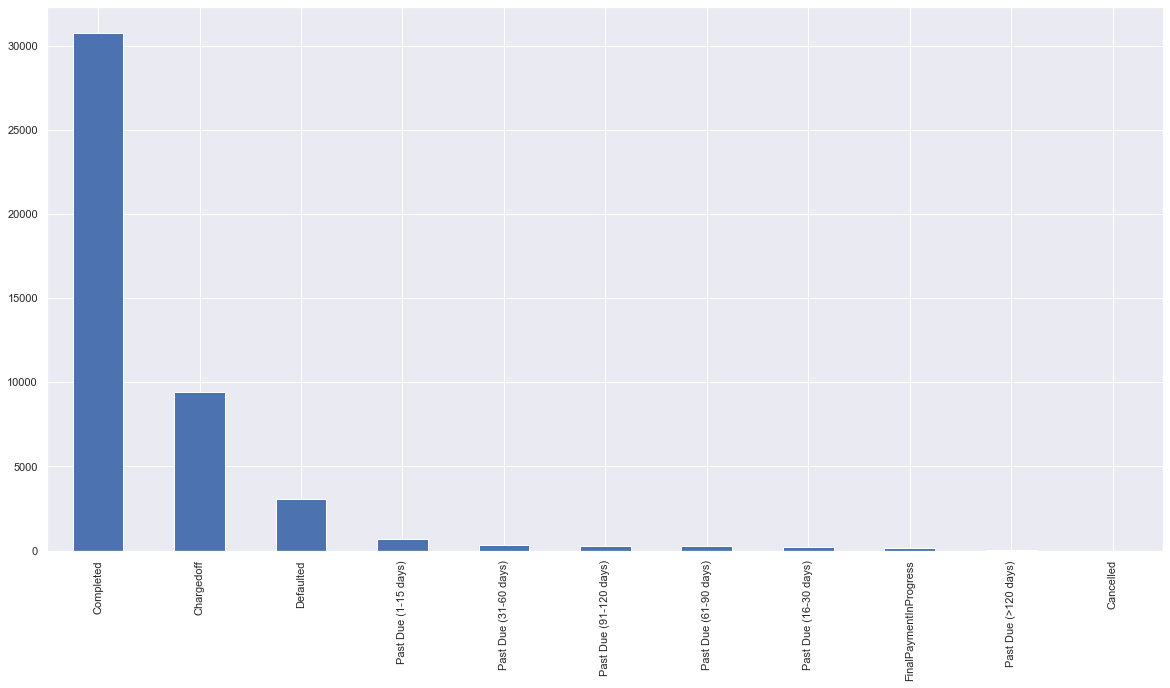

In [100]:
data_sub['LoanStatus'].value_counts().plot(kind = 'bar')

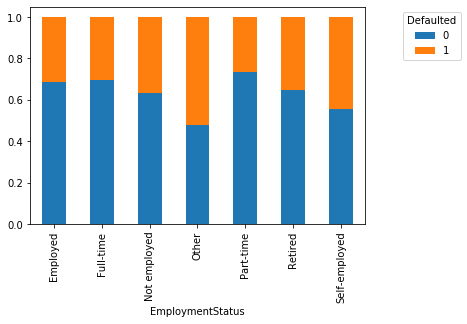

In [386]:
table=pd.crosstab(data.EmploymentStatus,data.Defaulted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(title='Defaulted',bbox_to_anchor=(1.1, 1))

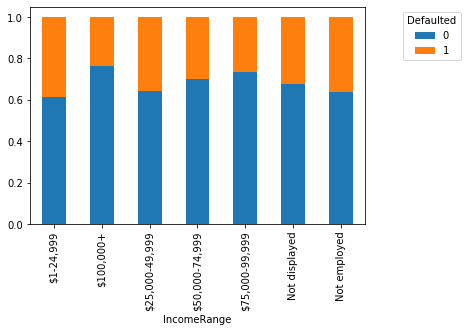

In [387]:
table=pd.crosstab(data.IncomeRange,data.Defaulted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(title='Defaulted',bbox_to_anchor=(1.1, 1))

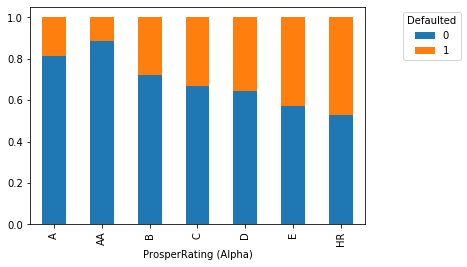

In [388]:
table=pd.crosstab(data['ProsperRating (Alpha)'],data.Defaulted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(title='Defaulted',bbox_to_anchor=(1.1, 1))

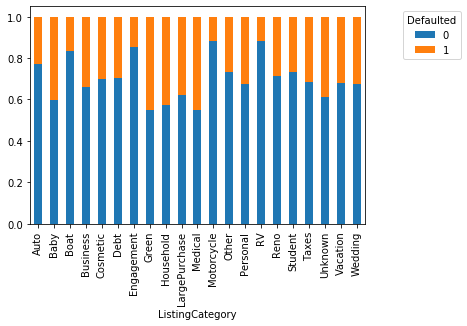

In [390]:
table=pd.crosstab(data['ListingCategory'],data.Defaulted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(title='Defaulted',bbox_to_anchor=(1.1, 1))

## Covert Categorical Variables

In [385]:
data.select_dtypes(include='object').columns

Index(['LoanStatus', 'ProsperRating (Alpha)', 'Occupation', 'EmploymentStatus',
       'IncomeRange'],
      dtype='object')

In [ ]:
data.replace(to_replace={"ListingCategory (numeric)": {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal",
                                                                5: "Student", 6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 
                                                                10: "Cosmetic", 11: "Engagement", 12: "Green", 13: "Household",
                                                                14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 17: "RV",
                                                                18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)
data.rename(index=str, columns={"ListingCategory (numeric)": "ListingCategory"}, inplace=True)
data.rename(index=str, columns={"ProsperRating (Alpha)": "ProsperRating"}, inplace=True)

In [ ]:
for var in ['ListingCategory','ProsperRating','IncomeRange','EmploymentStatus',]:
  dummy=pd.get_dummies(data[var], prefix=var,drop_first=True)
  data=data.join(dummy)
  data=data.drop(var,axis=1)

In [ ]:
#convert True/False into 1 and 0
data["IsBorrowerHomeowner"] = data["IsBorrowerHomeowner"].astype(int)
data["IncomeVerifiable"] = data["IncomeVerifiable"].astype(int)

Text(0.5, 1.0, 'Income Verifiable')

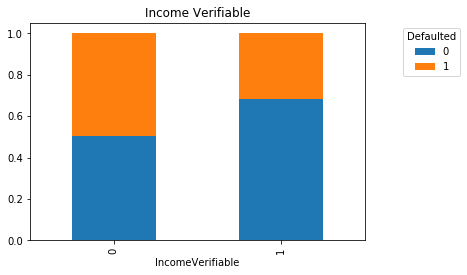

In [394]:
table=pd.crosstab(data.IncomeVerifiable,data.Defaulted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(title='Defaulted',bbox_to_anchor=(1.3, 1))
plt.title('Income Verifiable')

In [ ]:
##drop highly colinear variable and high dimensional variables
data=data.drop(['Occupation','BorrowerAPR','EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn','CreditScoreRangeUpper'],axis=1) #'ProsperRating',

In [396]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45269 entries, 0 to 45268
Data columns (total 71 columns):
Term                                   45269 non-null int64
BorrowerAPR                            45269 non-null float64
BorrowerRate                           45269 non-null float64
LenderYield                            45269 non-null float64
EstimatedEffectiveYield                45269 non-null float64
EstimatedLoss                          45269 non-null float64
EstimatedReturn                        45269 non-null float64
ProsperScore                           45269 non-null float64
EmploymentStatusDuration               45269 non-null float64
IsBorrowerHomeowner                    45269 non-null int64
CreditScoreRangeLower                  45269 non-null float64
CreditScoreRangeUpper                  45269 non-null float64
CurrentCreditLines                     45269 non-null float64
OpenCreditLines                        45269 non-null float64
TotalCreditLinespast7years      

In [397]:
data.shape

(45269, 71)

## Split Train Test Dataset

In [ ]:
data.rename(index=str, columns={"TradesNeverDelinquent (percentage)": "TradesNeverDelinquent",'IncomeRange_$100,000+':'IncomeRange_$100,000plus'}, inplace=True)
data.columns = [col.replace(',', '') for col in data.columns]
data.columns = [col.replace('-', '_') for col in data.columns]
data.columns = [col.replace(' ', '_') for col in data.columns]
data.columns = [col.replace('$', '') for col in data.columns]

In [399]:
data.head()

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted,ListingCategory_Baby,ListingCategory_Boat,ListingCategory_Business,ListingCategory_Cosmetic,ListingCategory_Debt,ListingCategory_Engagement,ListingCategory_Green,ListingCategory_Household,ListingCategory_LargePurchase,ListingCategory_Medical,ListingCategory_Motorcycle,ListingCategory_Other,ListingCategory_Personal,ListingCategory_RV,ListingCategory_Reno,ListingCategory_Student,ListingCategory_Taxes,ListingCategory_Unknown,ListingCategory_Vacation,ListingCategory_Wedding
0,36,0.16516,0.1580,0.1380,0.13462,0.0980,0.03662,6.0,2.0,1,640.0,659.0,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,1,3083.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,78,9425,330.43,1.0,0,0,0.0,258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,36,0.15033,0.1325,0.1225,0.10912,0.0980,0.01112,6.0,19.0,0,640.0,659.0,2.0,2.0,10.0,1,40.0,3.0,5.0,3.0,2224.0,1.0,0.0,0.0,1220.0,0.32,2580.0,7.0,0.40,0.0,0.27,1,1666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,77,1000,33.81,1.0,0,0,0.0,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,36,0.17969,0.1435,0.1335,0.12640,0.0524,0.07400,4.0,1.0,0,680.0,699.0,9.0,7.0,29.0,8,290.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,8624.0,0.70,3626.0,20.0,1.00,0.0,0.18,1,2416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,2,4000,137.39,1.0,0,0,0.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36,0.35797,0.3177,0.3077,0.28960,0.1650,0.12460,5.0,121.0,1,700.0,719.0,10.0,9.0,18.0,5,300.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9103.0,0.97,178.0,17.0,0.94,0.0,0.49,1,5500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140,8.0,23,4000,173.71,1.0,0,0,0.0,10,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,36,0.21488,0.2075,0.1975,0.18412,0.0980,0.08612,6.0,36.0,0,620.0,639.0,4.0,4.0,13.0,3,15.0,0.0,8.0,1.0,5200.0,5.0,1.0,0.0,134.0,0.08,1366.0,6.0,0.37,0.0,0.09,1,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,75,3000,112.64,1.0,0,0,0.0,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
X = data.drop("Defaulted", axis=1)
y = data["Defaulted"]

#### Calculate VIF to avoid multicoliearity

In [ ]:
%%capture
features = "+".join(X.columns)
#https://etav.github.io/python/vif_factor_python.html
#https://statisticalhorizons.com/multicollinearity
y_vif, X_vif = dmatrices('Defaulted~'+features, data, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
##select VIF smaller than 5 to avoid multicolinearity
selected_var = vif[vif["VIF Factor"] < 5]["features"].unique().tolist()

In [403]:
selected_var

['Intercept',
 'Term',
 'ProsperScore',
 'EmploymentStatusDuration',
 'IsBorrowerHomeowner',
 'OpenRevolvingMonthlyPayment',
 'InquiriesLast6Months',
 'TotalInquiries',
 'CurrentDelinquencies',
 'AmountDelinquent',
 'DelinquenciesLast7Years',
 'PublicRecordsLast10Years',
 'PublicRecordsLast12Months',
 'RevolvingCreditBalance',
 'BankcardUtilization',
 'AvailableBankcardCredit',
 'TradesNeverDelinquent',
 'TradesOpenedLast6Months',
 'DebtToIncomeRatio',
 'IncomeVerifiable',
 'StatedMonthlyIncome',
 'ProsperPrincipalBorrowed',
 'ProsperPrincipalOutstanding',
 'LoanCurrentDaysDelinquent',
 'LoanFirstDefaultedCycleNumber',
 'PercentFunded',
 'Recommendations',
 'InvestmentFromFriendsCount',
 'InvestmentFromFriendsAmount',
 'Investors',
 'ListingCategory_Baby',
 'ListingCategory_Boat',
 'ListingCategory_Business',
 'ListingCategory_Cosmetic',
 'ListingCategory_Engagement',
 'ListingCategory_Green',
 'ListingCategory_Household',
 'ListingCategory_LargePurchase',
 'ListingCategory_Medical',
 

In [ ]:
X_vif=X.loc[:,X.columns.isin(selected_var)]

In [406]:
X_vif.shape

(45269, 47)

In [407]:
## use stratified method to split train test dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=1234,stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2,stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(36215, 47) (36215,)
(9054, 47) (9054,)


In [409]:
X_train.head()

,Term,ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TradesNeverDelinquent,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,ListingCategory_Baby,ListingCategory_Boat,ListingCategory_Business,ListingCategory_Cosmetic,ListingCategory_Engagement,ListingCategory_Green,ListingCategory_Household,ListingCategory_LargePurchase,ListingCategory_Medical,ListingCategory_Motorcycle,ListingCategory_Other,ListingCategory_Personal,ListingCategory_RV,ListingCategory_Reno,ListingCategory_Student,ListingCategory_Taxes,ListingCategory_Vacation,ListingCategory_Wedding
22348,36,7.0,157.0,1,45.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,797.0,0.02,26703.0,1.00,1.0,0.08,1,5279.500000,0.0,0.00,0,0.0,1.0,0,0,0.0,348,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4027,36,6.0,5.0,1,278.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,9259.0,0.66,4591.0,0.85,0.0,0.23,1,5625.000000,0.0,0.00,0,0.0,1.0,0,0,0.0,187,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12818,36,6.0,116.0,0,334.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,8535.0,0.53,7500.0,1.00,0.0,0.27,1,3891.666667,0.0,0.00,0,0.0,1.0,0,0,0.0,205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5144,36,5.0,54.0,1,269.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,9047.0,0.92,235.0,1.00,3.0,0.14,1,3791.666667,4000.0,3177.13,0,0.0,1.0,0,0,0.0,55,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
41472,12,8.0,63.0,0,367.0,0.0,3.0,0.0,0.0,24.0,0.0,0.0,13772.0,0.64,7372.0,0.88,0.0,0.21,1,9583.333333,0.0,0.00,0,0.0,1.0,0,0,0.0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#scale variable between 0 and 1
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)

In [ ]:
X_train_scaled_50=pd.DataFrame(SelectPercentile(percentile=50).fit_transform(X_train_scaled, y_train))
X_test_scaled_50=pd.DataFrame(SelectPercentile(percentile=50).fit_transform(X_test_scaled, y_test))

In [431]:
X_train_scaled_50.head()

,Term,ProsperScore,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,BankcardUtilization,AvailableBankcardCredit,TradesNeverDelinquent,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,ProsperPrincipalBorrowed,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,InvestmentFromFriendsCount,Investors,ListingCategory_Household,ListingCategory_Medical,ListingCategory_Other
0,0.5,0.6,0.015873,0.012658,0.0,0.0,0.000000,0.0,0.0,0.003361,0.046649,1.00,0.05,0.007992,0.010923,0.000000,0.0,0.0,0.0,0.292088,0.0,0.0,1.0
1,0.5,0.5,0.000000,0.037975,0.0,0.0,0.000000,0.0,0.0,0.110924,0.008020,0.85,0.00,0.022977,0.011638,0.000000,0.0,0.0,0.0,0.156566,0.0,0.0,0.0
2,0.5,0.5,0.000000,0.025316,0.0,0.0,0.000000,0.0,0.0,0.089076,0.013102,1.00,0.00,0.026973,0.008052,0.000000,0.0,0.0,0.0,0.171717,0.0,0.0,0.0
3,0.5,0.4,0.015873,0.037975,0.0,0.0,0.000000,0.0,0.0,0.154622,0.000411,1.00,0.15,0.013986,0.007845,0.066666,0.0,0.0,0.0,0.045455,0.0,0.0,0.0
4,0.0,0.7,0.000000,0.018987,0.0,0.0,0.242424,0.0,0.0,0.107563,0.012878,0.88,0.00,0.020979,0.019828,0.000000,0.0,0.0,0.0,0.176768,0.0,0.0,0.0


In [ ]:
#sclaed train test dataset after removing multicolinearity
X_train_scaled_vif=X_train_scaled.loc[:,X_train_scaled.columns.isin(selected_var)]
X_test_scaled_vif=X_test_scaled.loc[:,X_train_scaled.columns.isin(selected_var)]

In [ ]:
#train test dataset after removing multicolinearity
X_train_vif=X_train.loc[:,X_train.columns.isin(selected_var)]
X_test_vif=X_test.loc[:,X_train.columns.isin(selected_var)]

In [73]:
X_train_scaled_vif.shape

(36215, 59)

In [ ]:
def rfe_feature(classifer,X_train,X_test,y_train,n):
  rfe = RFE(classifer, n)
  rfe = rfe.fit(X_train, y_train.values.ravel())
  X_train_rfe=X_train.loc[:,rfe.support_]
  X_test_rfe=X_test.loc[:,rfe.support_]
  return X_train_rfe,X_test_rfe

## Model building

### Logistic Regression

,precision,recall,f1-score,support,Model
0,0.705617,0.935995,0.804641,6187.000000,Logistic Regression
1,0.532468,0.157307,0.242865,2867.000000,Logistic Regression
accuracy,0.689419,0.689419,0.689419,0.689419,Logistic Regression
macro avg,0.619042,0.546651,0.523753,9054.000000,Logistic Regression
weighted avg,0.650788,0.689419,0.626751,9054.000000,Logistic Regression


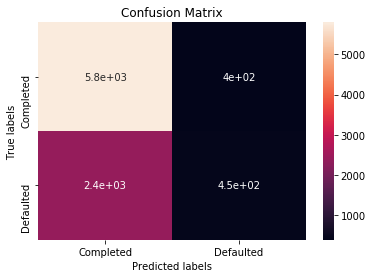

In [564]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
logmodel = LogisticRegressionCV(cv=5,penalty='l2')
logmodel.fit(X_train_scaled_50,list(y_train))
log_pred = logmodel.predict(X_test_scaled_50)

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,log_pred),annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Completed', 'Defaulted']); ax.yaxis.set_ticklabels(['Completed', 'Defaulted'])

log_metrics=pd.DataFrame.from_dict(classification_report(list(y_test),log_pred,output_dict=True)).transpose()
log_metrics['Model']='Logistic Regression'
log_metrics

### Decision Tree

,precision,recall,f1-score,support,Model
0,0.709451,0.701309,0.705356,6187.000000,Decision Tree
1,0.371001,0.380188,0.375538,2867.000000,Decision Tree
accuracy,0.599624,0.599624,0.599624,0.599624,Decision Tree
macro avg,0.540226,0.540749,0.540447,9054.000000,Decision Tree
weighted avg,0.602279,0.599624,0.600918,9054.000000,Decision Tree


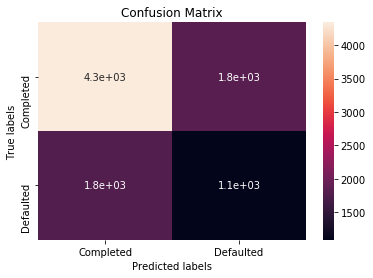

In [563]:
dt= DecisionTreeClassifier()
#X_train_rfe,X_test_rfe=rfe_feature(dt,X_train_vif,X_test_vif,y_train,10)
dt.fit(X_train_scaled_50,y_train)
dt_pred=dt.predict(X_test_scaled_50)

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,dt_pred),annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Completed', 'Defaulted']); ax.yaxis.set_ticklabels(['Completed', 'Defaulted'])

dt_metrics=pd.DataFrame.from_dict(classification_report(y_test,dt_pred,output_dict=True)).transpose()
dt_metrics['Model']='Decision Tree'
dt_metrics 

### Random Forest

,precision,recall,f1-score,support,Model
0,0.719103,0.865201,0.785416,6187.000000,Random Forest
1,0.481988,0.270666,0.346661,2867.000000,Random Forest
accuracy,0.676938,0.676938,0.676938,0.676938,Random Forest
macro avg,0.600545,0.567934,0.566038,9054.000000,Random Forest
weighted avg,0.644019,0.676938,0.646481,9054.000000,Random Forest


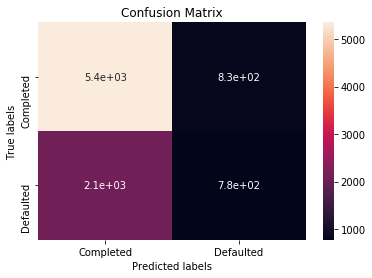

In [485]:
rf= RandomForestClassifier(n_estimators=500)
#X_train_rfe,X_test_rfe=rfe_feature(rf,X_train,X_test,y_train,20)
rf.fit(X_train_scaled_50,y_train)
rf_pred=rf.predict(X_test_scaled_50)
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,rf_pred),annot=True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Completed', 'Defaulted']); ax.yaxis.set_ticklabels(['Completed', 'Defaulted'])

rf_metrics=pd.DataFrame.from_dict(classification_report(y_test,rf_pred,output_dict=True)).transpose()
rf_metrics['Model']='Random Forest'
rf_metrics

### XGBoost

,precision,recall,f1-score,support,Model
0,0.717005,0.925489,0.808015,6187.00000,XGBoost
1,0.568352,0.211720,0.308513,2867.00000,XGBoost
accuracy,0.699470,0.699470,0.699470,0.69947,XGBoost
macro avg,0.642678,0.568604,0.558264,9054.00000,XGBoost
weighted avg,0.669933,0.699470,0.649845,9054.00000,XGBoost


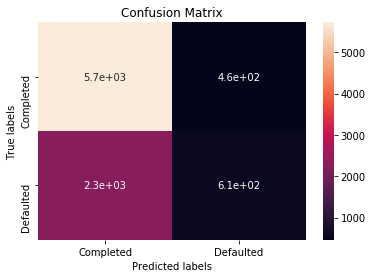

In [555]:
from xgboost import XGBClassifier
xgboost = XGBClassifier(n_estimators=1000)
xgboost.fit(X_train_scaled_50,y_train)
xg_pred = xgboost.predict(X_test_scaled_50)
xg_prob = xgboost.predict_proba(X_test_scaled_50)
##plot confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,xg_pred),annot=True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Completed', 'Defaulted'])
ax.yaxis.set_ticklabels(['Completed', 'Defaulted'])


xg_metrics = pd.DataFrame.from_dict(classification_report(y_test,xg_pred,output_dict=True)).transpose()
xg_metrics['Model']='XGBoost'
xg_metrics

### ANN (Artificial Neural Network)

,precision,recall,f1-score,support,Model
0,0.704114,0.954259,0.810321,6187.000000,ANN
1,0.576981,0.134636,0.218326,2867.000000,ANN
accuracy,0.694721,0.694721,0.694721,0.694721,ANN
macro avg,0.640548,0.544447,0.514323,9054.000000,ANN
weighted avg,0.663857,0.694721,0.622863,9054.000000,ANN


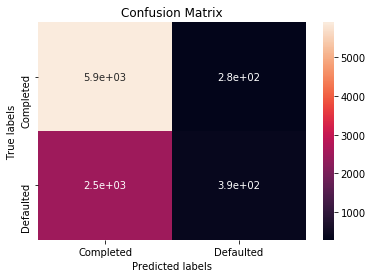

In [556]:
import keras 
from keras.layers import Dense
from keras.models import Sequential
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
ann  = Sequential()
ann.add(Dense(units= 32,init= 'uniform', activation = 'relu', input_dim=X_train_scaled_10.shape[1]))
ann.add(Dense(units= 32,init= 'uniform', activation = 'relu'))
ann.add(Dense(units= 1,init= 'uniform', activation = 'sigmoid'))
ann.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
ann.fit(X_train_scaled_10,y_train,epochs=10, batch_size=32)
ann_pred = ann.predict(X_test_scaled_50)
ann_pred = [ 1 if y>=0.5 else 0 for y in ann_pred]
ann_prob = ann.predict_proba(X_test_scaled_50)
##plot confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,ann_pred),annot=True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Completed', 'Defaulted'])
ax.yaxis.set_ticklabels(['Completed', 'Defaulted'])

ann_metrics=pd.DataFrame.from_dict(classification_report(y_test,ann_pred,output_dict=True)).transpose()
ann_metrics['Model']='ANN'
ann_metrics

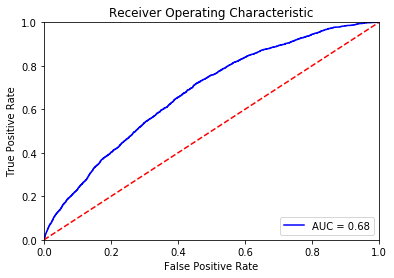

In [569]:
# plot roc-auc
model_roc_auc = roc_auc_score(y_test, ann_pred) 
fpr, tpr, threshold = roc_curve(y_test, ann_prob[:,0])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [567]:
## Combine Model result: ANN or XGBoost 
pd.concat([ann_metrics.iloc[:3,],log_metrics.iloc[:3,],dt_metrics.iloc[:3,],rf_metrics.iloc[:3,],xg_metrics.iloc[:3,]])

,precision,recall,f1-score,support,Model
0,0.704114,0.954259,0.810321,6187.000000,ANN
1,0.576981,0.134636,0.218326,2867.000000,ANN
accuracy,0.694721,0.694721,0.694721,0.694721,ANN
0,0.705617,0.935995,0.804641,6187.000000,Logistic Regression
1,0.532468,0.157307,0.242865,2867.000000,Logistic Regression
accuracy,0.689419,0.689419,0.689419,0.689419,Logistic Regression
0,0.709451,0.701309,0.705356,6187.000000,Decision Tree
1,0.371001,0.380188,0.375538,2867.000000,Decision Tree
accuracy,0.599624,0.599624,0.599624,0.599624,Decision Tree
0,0.719103,0.865201,0.785416,6187.000000,Random Forest


### Logistic Regression (indentify significant variables)

In [574]:
logit_model = sm.Logit(list(y_train), X_train_scaled_10)
result_logit = logit_model.fit(method='bfgs')
stats_sig_cols = [key for key, value in result_logit.pvalues.iteritems() if value < 0.05]

logit_model_sig = sm.Logit(list(y_train), X_train_scaled_10.loc[:,stats_sig_cols])
result_sig_logit = logit_model_sig.fit()
print(result_sig_logit.summary2())

         Current function value: 0.591626
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 0.588130
         Iterations 5


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.058     
Dependent Variable:     y                  AIC:                42614.2595
Date:                   2020-03-16 01:00   BIC:                42682.2373
No. Observations:       36215              Log-Likelihood:     -21299.   
Df Model:               7                  LL-Null:            -22609.   
Df Residuals:           36207              LLR p-value:        0.0000    
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         5.0000                                           
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Term                      0.8963   0.0539  16.6381 0.0000  0.7907  1.0018
ProsperScore             -2.7395   0.0554 -49.4173 0.0000 -2.8481 -2

## Result Prediction

From the model comparision, we can see that the XGBoost and ANN model have better results over others. We will use the predicition results of this two model to identify the defaulted loans in the training dataset and calculate potential loss of investos.

In [ ]:
test_data=pd.read_csv("My Drive/2020 Winter Group 23/BAX452/final prj/prosperLoanData.csv")

In [618]:
predict_result=pd.DataFrame(np.column_stack([y_test, dt_pred,ann_pred, xg_pred]), 
             columns=['LoanStatus', 'DecisionTree_prediction','ANN_prediction', 'XGBoost_prediction'])
predict_result_1=predict_result[predict_result['ANN_prediction']==1]
predict_result_1[:10]

,LoanStatus,DecisionTree_prediction,ANN_prediction,XGBoost_prediction
0,0,0,1,1
12,0,1,1,1
18,0,1,1,1
26,1,1,1,1
27,0,0,1,1
49,0,1,1,1
74,1,1,1,1
102,0,1,1,1
112,1,1,1,1
114,1,1,1,1


In [619]:
loans_complete = predict_result_1[predict_result_1["LoanStatus"] == 0]
loans_defaulted = predict_result_1[predict_result_1["LoanStatus"] == 1]

len(loans_defaulted), len(loans_complete), len(loans_defaulted) / (len(loans_complete) + len(loans_defaulted))

(386, 283, 0.5769805680119582)